## 1. Import

### 1.1 Import libraries

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

### 1.2 Import données

In [2]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex
PATH_Data:   /Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Test1
PATH_Result: /Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Results


## 2. Session Spark

### 2.1 Création d'une session Spark

ici nous allons créer une session Spark. La session Spark est le point d'entrée de toute fonctionnalité Spark. Lorsque vous créez une session Spark, Spark crée automatiquement un SparkContext pour vous.

Voici une décomposition de ce que fait le code :

- `SparkSession.builder` : C'est le point d'entrée pour créer une session Spark. Il permet de configurer les paramètres de la session.

- `.appName('P11')` : Cette méthode définit le nom de l'application Spark, qui sera 'P11' dans ce cas.

- `.master('local')` : Cette méthode définit le maître de la session Spark. 'local' signifie que la session Spark sera exécutée sur la machine locale.

- `.config("spark.sql.parquet.writeLegacyFormat", 'true')` : Cette méthode configure un paramètre spécifique pour la session Spark. Ici, il est configuré pour écrire les fichiers Parquet dans le format hérité.

- `.getOrCreate()` : Cette méthode crée la session Spark avec les paramètres configurés précédemment, ou récupère la session existante si elle existe déjà avec les mêmes paramètres.

Cette session Spark nous permettra d'exécuter des opérations Spark dans notre notebook.

In [3]:
spark = (SparkSession
             .builder
             .appName('P11')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/20 05:28:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Maintenant nous allons instancier une variable "sc" qui est un `spark context`

In [4]:
sc = spark.sparkContext

In [5]:
spark

### 2.2 Lecture des images avec Spark

Nous allons lire des images à l'aide de Spark. Pour ce faire, nous utilisons la méthode `read.format("binaryFile")` de l'objet `spark` que nous avons créé précédemment.

Voici une décomposition de ce que fait le code :

- `spark.read.format("binaryFile")` : Cette méthode indique à Spark que nous allons lire des fichiers binaires. Dans ce cas, il s'agit d'images au format .jpg.

- `.option("pathGlobFilter", "*.jpg")` : Cette option permet de filtrer les fichiers que nous voulons lire. Ici, nous indiquons que nous voulons lire uniquement les fichiers qui se terminent par .jpg.

- `.option("recursiveFileLookup", "true")` : Cette option indique à Spark de chercher des fichiers de manière récursive dans les sous-répertoires du chemin spécifié.

- `.load(PATH_Data)` : Cette méthode charge les fichiers du chemin spécifié. `PATH_Data` est une variable qui contient le chemin vers les données.

Ainsi, ce code lit toutes les images .jpg du chemin spécifié et de ses sous-répertoires.

In [6]:
# Read .jpg files from the directory
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

### 2.3 Ajout d'une colonne 'label' à notre DataFrame

Nous ajoutons une nouvelle colonne à notre DataFrame 'images'. Cette colonne, appelée 'label', est créée en extrayant le nom du dossier contenant chaque image à partir du chemin de l'image.

Voici comment cela fonctionne :

1. Nous divisons le chemin de chaque image en plusieurs parties en utilisant le caractère '/' comme séparateur.
2. Nous prenons l'avant-dernière partie, qui correspond au nom du dossier contenant l'image.
3. Nous ajoutons cette information comme une nouvelle colonne dans notre DataFrame.

Après avoir ajouté la colonne 'label', nous vérifions son ajout en affichant le schéma du DataFrame et les cinq premières lignes des colonnes 'path' et 'label'.

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'), -2))
print(images.printSchema())
print(images.select('path', 'label').show(5, False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------------------------------------------+----------+
|path                                                                                       |label     |
+-------------------------------------------------------------------------------------------+----------+
|file:/Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Test1/cucumber_3/r0_135.jpg|cucumber_3|
|file:/Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Test1/cucumber_3/r0_131.jpg|cucumber_3|
|file:/Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Test1/cucumber_3/r0_119.jpg|cucumber_3|
|file:/Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Test1/cucumber_3/r0_123.jpg|cucumber_3|
|file:/Users/zaccaria/Documents/Progetti/ocia/ociap11/P

## 3. Modélisation
### 3.1 MobilNetV2
 1. Nous chargeons le modèle **MobileNetV2** avec les poids **précalculés** 
    issus d'**imagenet** et en spécifiant le format de nos images en entrée
 2. Nous créons un nouveau modèle avec:
  - <u>en entrée</u> : l'entrée du modèle MobileNetV2
  - <u>en sortie</u> : l'avant dernière couche du modèle MobileNetV2

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [10]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 3.2 Diffusion des poids du modèle

Nous utilisons la fonction `broadcast` de Spark pour diffuser les poids du modèle à tous les nœuds du cluster. Cela permet d'assurer que tous les nœuds ont une copie des poids du modèle, ce qui est nécessaire pour effectuer des prédictions ou des mises à jour de modèle sur les données distribuées.

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### 3.3 Établissement du processus de chargement d'images et application de leur featurisation via pandas UDF

<u>La séquence d'appels est organisée comme suit</u> :

- Pandas UDF
  - Appliquer la featurisation à une série d'images pd.Series
   - Effectuer le prétraitement d'une image

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/zaccaria/.pyenv/versions/3.11.7/envs/projet11/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [14]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [15]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [16]:
print(PATH_Result)

/Users/zaccaria/Documents/Progetti/ocia/ociap11/P8_ex/data/Results


In [17]:
features_df.write.mode("overwrite").parquet(PATH_Result)

CodeCache: size=131072Kb used=19119Kb max_used=19464Kb free=111952Kb
 bounds [0x00000001069e8000, 0x0000000107d08000, 0x000000010e9e8000]
 total_blobs=7595 nmethods=6674 adapters=833
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step1) / 20]
1/1 ━━━━━━━━━━━━

## 4. Affichage Résultats
### 4.1 Affichage fatures

In [18]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [19]:
df.head()

,path,label,features
0,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[1.02809, 0.8522483, 0.08045385, 0.0, 0.356502..."
1,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[0.95385385, 0.76120776, 0.08793997, 0.0, 0.53..."
2,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[1.1315358, 0.10197912, 0.86285293, 0.0, 0.352..."
3,file:/Users/zaccaria/Documents/Progetti/ocia/o...,pear_1,"[0.9297638, 0.0043686945, 0.0, 0.0, 0.0, 0.028..."
4,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[0.75672734, 0.41874787, 0.028314425, 0.019886..."


In [20]:
df.loc[0,'features'].shape

(1280,)

### 4.2 Affichage avec t-SNE

Nous allons faire appel à la technique de visualisation de données appelée **t-SNE** (t-Distributed Stochastic Neighbor Embedding). Cette méthode est particulièrement efficace pour la visualisation de données à haute dimension, comme c'est le cas avec nos images.

#### Objectif

L'objectif est de voir si, en réduisant la dimensionnalité de nos données, nous pouvons toujours distinguer clairement les différentes classes d'images. Si c'est le cas, cela indiquerait que nos caractéristiques sont suffisamment informatives pour séparer les différentes classes, même dans un espace à dimension réduite.
Cela serait une bonne nouvelle pour notre modèle de classification, car cela signifierait qu'il a une chance raisonnable de bien performer, même si nous devons réduire le nombre de caractéristiques pour des raisons de calcul.

#### En synthèse

En somme, l'application de t-SNE à nos données nous donnera une meilleure idée de la structure sous-jacente de nos données et de la faisabilité de notre tâche de classification.

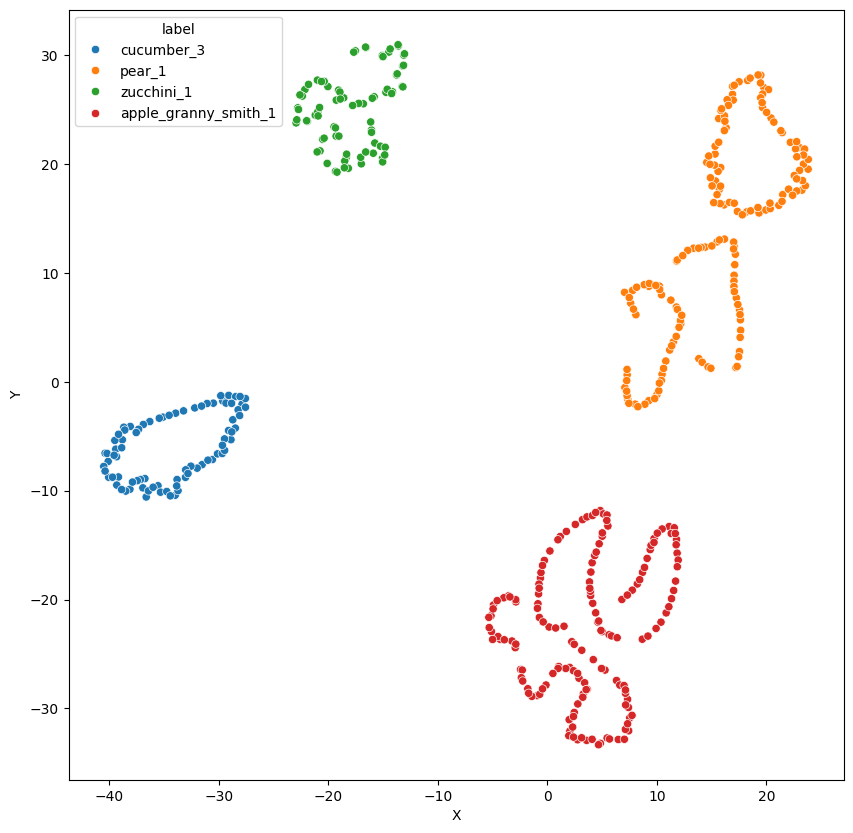

In [21]:
# Assuming df is your DataFrame
features = df['features'].apply(lambda x: np.array(x))

# Convert features into a 2D array
features_2d = np.array(features.tolist())

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Apply t-SNE to the data
tsne_results = tsne.fit_transform(features_2d)

# Create a DataFrame with t-SNE results and labels
tsne_df = pd.DataFrame({'X': tsne_results[:, 0], 'Y': tsne_results[:, 1], 'label': df['label']})

# Plot the results with labels as hue
plt.figure(figsize=(10, 10))
sns.scatterplot(x='X', y='Y', hue='label', data=tsne_df)
plt.show()

**Analyse T-SNE :** Notre analyse T-SNE nous permet de distinguer clairement les différentes catégories dans notre jeu de données. C'est une indication que nos caractéristiques sont assez informatives pour séparer les différentes classes d'images.

**Apparition de sous-catégories :** Nous observons l'apparition de sous-catégories, en particulier dans les classes de pommes et de poires. Cela pourrait être dû au fait que ces classes ont un plus grand nombre d'images par rapport aux autres. En effet, un plus grand nombre d'images offre une plus grande variété de caractéristiques, ce qui peut conduire à la formation de sous-groupes au sein de la même catégorie.

**Interprétation des sous-groupes :** Ces sous-groupes pourraient représenter différentes variétés de pommes et de poires, ou des différences dans la façon dont les images ont été prises, comme l'éclairage, l'angle de la caméra, ou le degré de maturité des fruits. 

**Implication pour le modèle de classification :** Cependant, le fait que nous observons ces sous-catégories indique que notre modèle est capable de capturer une grande quantité de détails dans les données, ce qui est prometteur pour la performance de notre modèle de classification.

### 4.3 PCA 

Nous allons maintenant effectuer une **Analyse en Composantes Principales (PCA)** sur notre ensemble de données. 

#### Préparation des données

Pour commencer, nous définissons une **fonction utilisateur (UDF)** qui convertit un tableau en un vecteur. C'est une étape nécessaire car la fonction PCA de PySpark attend des données sous forme de vecteurs.

Ensuite, nous chargeons notre ensemble de données à partir d'un fichier **Parquet**. Parquet est un format de fichier optimisé pour le stockage en colonnes, ce qui est idéal pour les grands ensembles de données.

Une fois les données chargées, nous convertissons une colonne de l'ensemble de données, qui est un tableau de nombres à virgule flottante, en un vecteur à l'aide de l'UDF que nous avons définie.

#### Application de la PCA

Maintenant, nous sommes prêts à appliquer la PCA à la colonne de vecteurs. Nous spécifions que nous voulons deux composantes principales avec le paramètre `k`.

Après avoir appliqué la PCA, nous supprimons la colonne de vecteurs originale de l'ensemble de données. Cela nous permet d'économiser de l'espace, car cette colonne n'est plus nécessaire.

#### Conversion en DataFrame Pandas

Enfin, nous convertissons l'ensemble de données Spark en un **DataFrame Pandas**. Cela nous permet d'utiliser facilement les données avec des bibliothèques Python qui s'attendent à des DataFrames Pandas.



In [22]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT

# Define a UDF to convert array to vector
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Load the data
df = spark.read.parquet(PATH_Result)

# Convert the array of floats to a vector
df = df.withColumn("features_vec", list_to_vector_udf(df["features"]))

# Apply PCA
pca = PCA(k=2, inputCol="features_vec", outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df)
result = result.drop('features_vec')
result = result.drop('features')
# Convert the Spark DataFrame to a Pandas DataFrame
result_pd = result.toPandas()


24/06/20 05:29:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/20 05:29:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [23]:
result_pd.head()

,path,label,pcaFeatures
0,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[11.308647269291315, -4.089936426123957]"
1,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[10.564156308055871, -4.0341143125233065]"
2,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[12.559707640014853, -3.3085778039897167]"
3,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[10.112701970729733, -2.994906086358103]"
4,file:/Users/zaccaria/Documents/Progetti/ocia/o...,cucumber_3,"[12.475473290124103, -5.459863035549889]"


In [24]:
# Save the DataFrame to a CSV file
result_pd.to_csv(os.path.join(PATH_Result, 'result.csv'), index=False)